# Sparkify Project Workspace

Workspace to investigate predicting user churn (account cancellation) for a fictional music app (Sparkify).  This project takes user action records (user info, page visited, timestamp, etc) as inputs.  These records will then be engineered to build features.  The resulting feature will used to generate a ML model for prediction.  Spark will be utilized to facilitate the analysis.

In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col,count, desc, avg, max, min, countDistinct, when, isnan, split
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify subset") \
    .getOrCreate()

# Load and Clean Dataset

For analysis we will use a mini-dataset file (`mini_sparkify_event_data.json`).  This set will be loaded and checked for invalid or missing data.  We will focus on the attributes that will be most useful for our study.  These include page, userId, ts.

In [3]:
# read in sample data
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
# investigate data schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Check for NA or null entries
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [6]:
# Check userId for any unusual entries
df.select('userId').distinct().collect()

[Row(userId='100010'),
 Row(userId='200002'),
 Row(userId='125'),
 Row(userId='51'),
 Row(userId='124'),
 Row(userId='7'),
 Row(userId='54'),
 Row(userId='15'),
 Row(userId='155'),
 Row(userId='132'),
 Row(userId='154'),
 Row(userId='100014'),
 Row(userId='101'),
 Row(userId='11'),
 Row(userId='138'),
 Row(userId='300017'),
 Row(userId='29'),
 Row(userId='69'),
 Row(userId='100021'),
 Row(userId='42'),
 Row(userId='112'),
 Row(userId='87'),
 Row(userId='73'),
 Row(userId='64'),
 Row(userId='200010'),
 Row(userId='3'),
 Row(userId='30'),
 Row(userId='113'),
 Row(userId='34'),
 Row(userId='133'),
 Row(userId='59'),
 Row(userId='146'),
 Row(userId='139'),
 Row(userId='8'),
 Row(userId='28'),
 Row(userId='22'),
 Row(userId='300018'),
 Row(userId='300012'),
 Row(userId='100022'),
 Row(userId='85'),
 Row(userId='52'),
 Row(userId='35'),
 Row(userId='16'),
 Row(userId='300008'),
 Row(userId='71'),
 Row(userId='98'),
 Row(userId='300013'),
 Row(userId='99'),
 Row(userId='47'),
 Row(userId='100

In [7]:
# Check page for any unusual entries
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [8]:
# Check range of ts to make sure it makes sense
df.select('ts').agg(max('ts'),min('ts')).show()

+-------------+-------------+
|      max(ts)|      min(ts)|
+-------------+-------------+
|1543799476000|1538352117000|
+-------------+-------------+



It appears as if the dataset is quite clean.  There are only missing entries for columns where we would expect missing info (for example artisit and song will be missing for page actions that do not include songs, etc).  Additionally, our focus columns only include entries that make sense.  Thus it is felt that cleaning will not be required.

# Exploratory Data Analysis

Our exploratory data analysis will be performed in 3 steps.  First we will gain a better understanding of the dataset.  Next the key classification (churn) will be defined and added to the set.  Finally we will investigate hypotheses to try and identify features to include in our model.

## Gain understanding of dataset

We start by looking at some general dataset information to get a feel for what the dataset looks like (format of columns, number of rows, cvount of users, etc).  Additionally we will transform any columns that will help us to better utilize the column information (example convert timestamp to date for ease of understanding).

In [9]:
# look at a record
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [10]:
# total number of records
df.count()

286500

In [11]:
# total number of users
df.select("userId").dropDuplicates().count()

226

In [12]:
# Distribution of pages visited
df.groupBy("page").count().collect()

[Row(page='Cancel', count=52),
 Row(page='Submit Downgrade', count=63),
 Row(page='Thumbs Down', count=2546),
 Row(page='Home', count=14457),
 Row(page='Downgrade', count=2055),
 Row(page='Roll Advert', count=3933),
 Row(page='Logout', count=3226),
 Row(page='Save Settings', count=310),
 Row(page='Cancellation Confirmation', count=52),
 Row(page='About', count=924),
 Row(page='Submit Registration', count=5),
 Row(page='Settings', count=1514),
 Row(page='Login', count=3241),
 Row(page='Register', count=18),
 Row(page='Add to Playlist', count=6526),
 Row(page='Add Friend', count=4277),
 Row(page='NextSong', count=228108),
 Row(page='Thumbs Up', count=12551),
 Row(page='Help', count=1726),
 Row(page='Upgrade', count=499),
 Row(page='Error', count=258),
 Row(page='Submit Upgrade', count=159)]

In [13]:
# Number of users going to each page
df.select("userId","page").dropDuplicates().groupBy("page").agg({"userId":"count"}).collect()

[Row(page='Cancel', count(userId)=52),
 Row(page='Submit Downgrade', count(userId)=49),
 Row(page='Thumbs Down', count(userId)=203),
 Row(page='Home', count(userId)=224),
 Row(page='Downgrade', count(userId)=154),
 Row(page='Roll Advert', count(userId)=207),
 Row(page='Logout', count(userId)=213),
 Row(page='Save Settings', count(userId)=132),
 Row(page='Cancellation Confirmation', count(userId)=52),
 Row(page='About', count(userId)=156),
 Row(page='Submit Registration', count(userId)=1),
 Row(page='Settings', count(userId)=195),
 Row(page='Login', count(userId)=1),
 Row(page='Register', count(userId)=1),
 Row(page='Add to Playlist', count(userId)=215),
 Row(page='Add Friend', count(userId)=206),
 Row(page='NextSong', count(userId)=225),
 Row(page='Thumbs Up', count(userId)=220),
 Row(page='Help', count(userId)=193),
 Row(page='Upgrade', count(userId)=168),
 Row(page='Error', count(userId)=118),
 Row(page='Submit Upgrade', count(userId)=131)]

In [14]:
# convert ts to date
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'))
df = df.withColumn('date', get_date(df.ts))

In [15]:
# look at data time range
df.agg(min('date').alias('start_date'),max('date').alias('end_date')).show()

+----------+----------+
|start_date|  end_date|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



## Define Churn

The goal for this analysis is to understand user churn.  For this study churn means that a user has confirmed cancellation of thier account (either paid or free account).  To help with future work we will identify the rows where churn transaction occurs (actions with page equal to 'Cancellation Confirmation').  Additionally for users with a churn action we will tag all of their actions with identification that they are a user with churn.

In [16]:
# create column churn to flag churn events
flag_churn = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn",flag_churn("page"))

# confirm count matches page='Cancellation Confirmation' count above (52)
df.filter(df.churn==1).count() 

52

In [17]:
# create column churn_user to identify users with a churn event
windowval = Window.partitionBy("userId")
df = df.withColumn("churn_user", Fsum("churn").over(windowval))

In [18]:
# find some users with a churn action for testing
df.select("userId").filter(df.page == "Cancellation Confirmation").dropDuplicates().take(5)

[Row(userId='125'),
 Row(userId='51'),
 Row(userId='54'),
 Row(userId='100014'),
 Row(userId='101')]

In [19]:
# check columns for user 125
df.filter(df.userId=='125').select('ts','page','churn','churn_user').orderBy('ts').show()

+-------------+--------------------+-----+----------+
|           ts|                page|churn|churn_user|
+-------------+--------------------+-----+----------+
|1539317144000|            NextSong|    0|         1|
|1539317481000|            NextSong|    0|         1|
|1539317711000|            NextSong|    0|         1|
|1539317914000|            NextSong|    0|         1|
|1539318124000|            NextSong|    0|         1|
|1539318515000|            NextSong|    0|         1|
|1539318728000|            NextSong|    0|         1|
|1539318906000|            NextSong|    0|         1|
|1539318917000|         Roll Advert|    0|         1|
|1539318918000|              Cancel|    0|         1|
|1539318918000|Cancellation Conf...|    1|         1|
+-------------+--------------------+-----+----------+



## Exploratory Data 

Now that we have churn identified we can start to explore the behavior of users that churn vs those that do not.  This exploration will investigate a number of hypotheses to establish some intuition regarding the data and help us prepare for feature engineering.  The hypotheses that are investigated are:
* Free members are more likely to leave than paid users.  We might expect this as it is assumed a paid member would downgrade to free before quiting.  Additionally, it is felt that the ads might drive a free user to quit.
* Users that churn will have a lower frequency of usage (visit the site less often).
* Users that churn listen to less songs per day that they log in.
* Users that churn will visit different pages than those that don't.  Perhaps have to visit help pages more often, give thumbs down more often, etc.

### Hypothesis 1: Free members are more likely to churn
For this we will look at distribution of level for users that have churned and compare to that of user that do not.

In [20]:
# level at time of churn
df.filter(df.churn==1).groupBy("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [21]:
# number of users by account level and churn
# note: may double count users as they could have been both levels during the span of time covered 
df.select("userId","level","churn").dropDuplicates().groupBy("level","churn").agg({"userID":"count"}).show()

+-----+-----+-------------+
|level|churn|count(userID)|
+-----+-----+-------------+
| paid|    0|          166|
| free|    0|          196|
| paid|    1|           31|
| free|    1|           21|
+-----+-----+-------------+



It appears as our hypothesis is off.  Only 40% of users that churned were free.  However for users that stay we find more free users.  Nonetheless this feature does show differentiation, so could be interesting to include in our model

### Hypothesis 2: Users that churn will visit site less days
For this we will look at distribution of number of days with actions by user.

In [22]:
# average numbers of days visited by user and churn
user_visits_day = df.select('userId','churn_user','date').distinct().groupBy('userId','churn_user').count()
user_visits_day.groupBy('churn_user').agg(avg('count')).show()

+----------+------------------+
|churn_user|        avg(count)|
+----------+------------------+
|         0|15.367816091954023|
|         1| 9.826923076923077|
+----------+------------------+



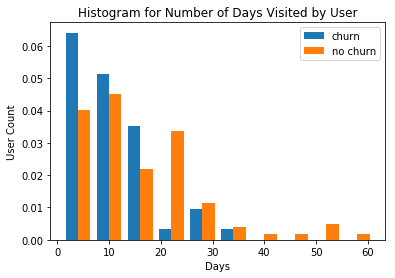

In [23]:
# plot histogram of number of days visited
visit_day_df = user_visits_day.toPandas()

plt.title("Histogram for Number of Days Visited by User")
plt.xlabel("Days")
plt.ylabel("User Count")
plt.hist([visit_day_df[visit_day_df.churn_user==1]['count'],
          visit_day_df[visit_day_df.churn_user==0]['count']],
        label=['churn','no churn'],normed=1)
plt.legend(loc='upper right')
plt.show();

Churn users tend to have less days with visits than non-churn users.  However this may be skewed as churn users may have a lower number of days that they had accounts.  We'll need to investigate total possible number of days and percent of possible days a user visited the site.

In [24]:
# total possible days by user

delta_day = udf(lambda x,y: 
            (datetime.datetime.strptime(x, '%Y-%m-%d')-datetime.datetime.strptime(y, '%Y-%m-%d')).days + 1, IntegerType())

user_possible = df.groupBy('userId','churn_user') \
    .agg(max('date').alias('end'),min('date').alias('start')) 
    
user_possible = user_possible.withColumn("days", delta_day(user_possible.end,user_possible.start))

user_possible.groupBy('churn_user').agg(avg('days').alias('total_possible_days')).show()


+----------+-------------------+
|churn_user|total_possible_days|
+----------+-------------------+
|         0|  48.00574712643678|
|         1|  24.46153846153846|
+----------+-------------------+



In [25]:
# percent of possible days visited by user
possible_df = user_possible.toPandas()
merged_usage = visit_day_df.merge(possible_df,on=['userId','churn_user'])
merged_usage['Percent_days_visited'] = merged_usage['count'] / merged_usage['days'] *100

merged_usage.groupby('churn_user')['Percent_days_visited'].mean()

churn_user
0    34.160709
1    52.465812
Name: Percent_days_visited, dtype: float64

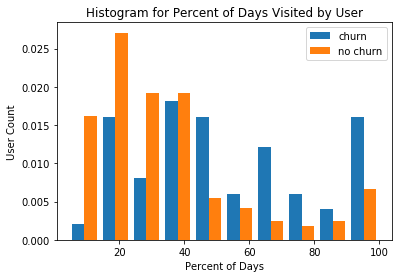

In [51]:
# Plot percent of days visited by churn

plt.title("Histogram for Percent of Days Visited by User")
plt.xlabel("Percent of Days")
plt.ylabel("User Count")
plt.hist([merged_usage[merged_usage.churn_user==1]['Percent_days_visited'],
          merged_usage[merged_usage.churn_user==0]['Percent_days_visited']],
        label=['churn','no churn'],normed=1)
plt.legend(loc='upper right');

plt.savefig('percent_days.jpg', bbox_inches='tight')

Again our hypothesis seems to be off.  Churn users do indeed visit less days.  However they also have lower possible number of days to visit (days while account is active).  After calculating the rate of daily usage we find churn users visit a much high percent of days.  Again this feature shows differentiation, so we will include in our model.

### Hypothesis 3: Users that churn listen to less music the days they visit site
For this we will look at distribution of "NextSong" page counts by user and date.

In [27]:
# number of songs listened to by day by churn

daily_songs_avg = df.filter(df.page=='NextSong') \
    .groupBy('userId','churn_user','date') \
    .agg(count('page').alias('songs')) \
    .groupBy('userId','churn_user') \
    .agg(avg('songs').alias('daily_avg')) \
    .toPandas()

daily_songs_avg.groupby('churn_user')['daily_avg'].mean()

churn_user
0    64.988984
1    62.536538
Name: daily_avg, dtype: float64

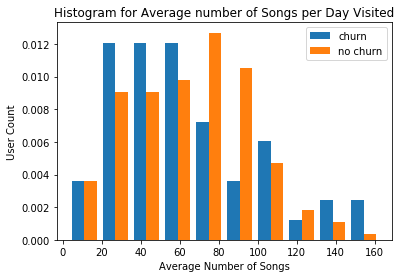

In [52]:
#plot distribution of average number of songs listened to each day visited

plt.title("Histogram for Average number of Songs per Day Visited")
plt.xlabel("Average Number of Songs")
plt.ylabel("User Count")
plt.hist([daily_songs_avg[daily_songs_avg.churn_user==1]['daily_avg'],
          daily_songs_avg[daily_songs_avg.churn_user==0]['daily_avg']],
        label=['churn','no churn'], normed=1)
plt.legend(loc='upper right');

plt.savefig('songs_day.jpg', bbox_inches='tight')

Again our hypotehsis seems disproved.  Additionally there seems to be little differentiation both in the overall average and the distribution by users.  Thus this is a feature we will not look to include in our model.

### Hypothesis 4: Churn users visit some pages more or less often than other users
For this item we will look at total count of page visits and compare the ranking between the groups to see if there are differences that look interesting.

In [29]:
# frequency of page visits by churn

page_visits_churn = df.filter(df.churn_user==1).groupBy('page') \
    .agg(count('page').alias('visits'),countDistinct('userId').alias('users')) \
    .orderBy('visits',ascending=True).toPandas()


page_visits_nochurn = df.filter(df.churn_user==0).groupBy('page') \
    .agg(count('page').alias('visits'),countDistinct('userId').alias('users')) \
    .orderBy('visits',ascending=True).toPandas()

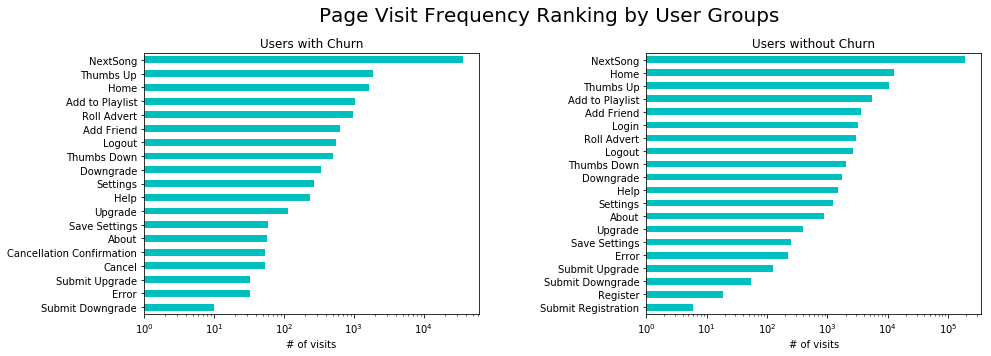

In [48]:
# Plot page ranking by count by group
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

fig.suptitle("Page Visit Frequency Ranking by User Groups",size=20)
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.5)


page_visits_churn.plot.barh(x='page',y='visits',color='c',legend=False, ax=ax[0],log=True)
ax[0].set_title('Users with Churn')
ax[0].set_xlabel('# of visits')
ax[0].set_ylabel('')


page_visits_nochurn.plot.barh(x='page',y='visits',color='c',legend=False, ax=ax[1],log=True)
ax[1].set_title('Users without Churn')
ax[1].set_xlabel('# of visits')
ax[1].set_ylabel('');

plt.savefig('page_frequency.jpg', bbox_inches='tight')

This hypothesis seems to be proved.  There are a few pages that differ significantly in ranking.  Some exmaples are: Roll Advert, Error.  Additionally we have a few page that non-churn user visit that churn users do not visit (Login, Register, Submit Registration).  We should consider these  in our model.

# Feature Engineering
Now that we have a better understanding of the dataset and some features we think are interesting (based on our hypothesis investigations), we can move on to feature engineering.  In this section we will transform the dataset to create a new set including the following:
* userId - primary key
* level - either free, paid, or both (having at one time switched level within the timeframe)
* visit_rate - fraction of days the user visited site
* page visit counts for:
    * Roll Advert
    * Error
    * Login
    * Register
    * Submit Registration
    * other_pages - sum of all other page visit counts
* churn- item we are attempting to predict

For this effort we will build up stepwise and then convert to a function that performs the full feature engineering (such as it can easily be applied to other datasets).

In [31]:
# read in fresh copy of sample data
df_fe = spark.read.json("mini_sparkify_event_data.json")

In [32]:
# create function to convert timestamp column to date

def convert_ts(df):
    '''
    Function convert column with timestamp to a date in form yyyy-mm-dd
    Input:
        df : pyspark dataframe including action data
    Output:
        pyspark dataframe including original data and added column "churn" 
            indicating user has churn event
    '''
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'))
    df = df.withColumn('date', get_date('ts'))
    df = df.drop('ts')
    
    return(df)

In [33]:
# create function to determine churn for each user

def get_churn(df):
    '''
    Function to add indicator that user has a churn event.
    Input:
        df : pyspark dataframe including action data
    Output:
        pyspark dataframe including userid and churn indicator
    '''
    
    flag_churn = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
    df = df.select('userId','page').withColumn("churn_flag",flag_churn("page"))
    
    windowval = Window.partitionBy("userId")
    df = df.withColumn("churn", Fsum("churn_flag").over(windowval))
    df = df.drop("churn_flag","page").distinct()
    
    return(df)

In [34]:
# create function to determine level (paid, free, both) for each user

def get_level(df):
    '''
    Function determine account level (paid, free, both) for each user
    Input:
        df : pyspark dataframe including action data
    Output:
        pyspark dataframe including userid and account level (paid, free, both)
    '''
        
    flag_paid = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    level_type = udf(lambda x,y: "paid" if x+y==2 else ("both" if x+y==1 else "free"))
    
    df = df.select('userId','level').distinct() \
        .withColumn("paid_flag",flag_paid("level")) \
        .groupBy('userId') \
        .agg(max("paid_flag").alias('max'),min("paid_flag").alias('min'))
    
    df = df.withColumn('level',level_type('max','min')).drop('max','min')

    return(df)


In [35]:
# create function to determine fraction of days visited for each user

def get_visit_frac(df):
    '''
    Function determine fraction of days visited for each user
    Input:
        df : pyspark dataframe including action data
    Output:
        pyspark dataframe including userid and fraction of days that teh user visited site
    '''
    
    visits = df.select('userId','date').distinct().groupBy('userId').count()


    delta_day = udf(lambda x,y: 
            (datetime.datetime.strptime(x, '%Y-%m-%d')-datetime.datetime.strptime(y, '%Y-%m-%d')).days + 1, IntegerType())

    days = df.groupBy('userId') \
        .agg(max('date').alias('end'),min('date').alias('start')) 
    
    days = days.withColumn("days", delta_day('end','start')) \
        .drop('end','start')

    merged = visits.join(days,on='userId')
    merged = merged.withColumn('visit_rate',col('count')/col('days')) \
        .drop('count','days')
    
    return(merged)

In [36]:
# create function to return page visit counts

def get_page_visits(df):
    '''
    Function determine fraction of days visited for each user
    Input:
        df : pyspark dataframe including action data
    Output:
        pyspark dataframe including the page visit counts
    '''
    
    df = df.select('userId','page')
    interest_pages = ['Roll Advert','Error','Login','Register','Submit Registration']

    rename_page = udf(lambda x: 'other' if x not in interest_pages else x)
    df = df.withColumn('page_adj',rename_page('page'))
    df = df.groupBy('userID').pivot('page_adj').count().na.fill(0)
    
    return(df)

In [37]:
# function to bring it all together

def feature_eng(df):
    '''
    Function determine fraction of days visited for each user
    Input:
        df : pyspark dataframe including action data
    Output:
        pyspark dataframe including all of engineered features and associated labels
    '''
    df = df.select('userId','level','ts','page')
    df = convert_ts(df)
    
    output = get_churn(df_fe)
    
    df_level = get_level(df)
    output = output.join(df_level, on='userId')
    
    df_visit = get_visit_frac(df)
    output = output.join(df_visit, on='userId')
    
    df_pages = get_page_visits(df)
    output = output.join(df_pages, on='userId')
    
    return(output)

df_fe_output = feature_eng(df_fe)


In [38]:
df_fe_output.show()

+------+-----+-----+-------------------+-----+-----+--------+-----------+-------------------+-----+
|userId|churn|level|         visit_rate|Error|Login|Register|Roll Advert|Submit Registration|other|
+------+-----+-----+-------------------+-----+-----+--------+-----------+-------------------+-----+
|100010|    0| free|0.15555555555555556|    0|    0|       0|         52|                  0|  329|
|200002|    0| both|0.15217391304347827|    0|    0|       0|          7|                  0|  467|
|   125|    1| free|                1.0|    0|    0|       0|          1|                  0|   10|
|   124|    0| paid| 0.5409836065573771|    6|    0|       0|          4|                  0| 4815|
|    51|    1| paid| 0.7647058823529411|    1|    0|       0|          0|                  0| 2463|
|     7|    0| free|0.15384615384615385|    1|    0|       0|         16|                  0|  184|
|    15|    0| paid| 0.3392857142857143|    2|    0|       0|          1|                  0| 2275|


# Modeling
Next we move into model development.  First we will split the feature engineered dataset into train, validation, and test sets.  We will then train preliminary versions of models.  Once trained we will test the preliminary models using the validation set to determine the model we want to move forward with.  Tuning will then be performed on the best model.  Once tuned we will test the model on the training set to understand the final performance.

## Spit dataset
Feature engineered dataset is split into test, validation,a nd trainng datasets.

In [39]:
#split set into training, test, and validation sets
train, rest = df_fe_output.randomSplit([0.6, 0.4], seed=42)
test,validation = rest.randomSplit([0.5, 0.5], seed=42)

## Build and Train Models
We will build and train models using three different classifiers (RandomForestClassifier,LogisticRegression, and GBTClassifier).  These models where chosen as they are fairly common and relatively easy to interrupt.  A pipeline is built for each classifier including:
* OneHotEncoding for the categorical feature (level)
* Feature scaling for via Normalizer for the page visit counts.  Normalizer as chosen as realtive counts are more important than the actual count number.
* Vector assembly via VectorAssembler
* The assocaited classifier (using mostly default settings)

Each pipeline is then trained using the training set

In [40]:
# Build pipeline and train model for Random Forest
levelIndexer = StringIndexer(inputCol="level", outputCol="level_ind")
levelEncoder = OneHotEncoder(inputCol='level_ind', outputCol='level_encode')
pageAssembler = VectorAssembler(inputCols=['Roll Advert','Error','Login','Register','Submit Registration','other'], 
                            outputCol="page_visits")
pageScaler = Normalizer(inputCol='page_visits', outputCol='scaled_page_visits')
featureAssembler = VectorAssembler(inputCols=['level_encode','visit_rate','scaled_page_visits'], 
                            outputCol='features')

rf = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=10)

pipeline_rf = Pipeline(stages=[levelIndexer,levelEncoder,pageAssembler,pageScaler,featureAssembler,rf])

model_rf = pipeline_rf.fit(train)

In [41]:
# Build pipeline and train model for LogisticRegression
lr = LogisticRegression(labelCol='churn', featuresCol='features',maxIter=10)

pipeline_lr = Pipeline(stages=[levelIndexer,levelEncoder,pageAssembler,pageScaler,featureAssembler,lr])

model_lr= pipeline_lr.fit(train)

In [42]:
# Build pipeline and train model for GBTClassifier
gbt = GBTClassifier(labelCol='churn', featuresCol='features',maxIter=10)

pipeline_gbt = Pipeline(stages=[levelIndexer,levelEncoder,pageAssembler,pageScaler,featureAssembler,gbt])

model_gbt= pipeline_gbt.fit(train)

## Preliminary Model Evaluation
Each of the three models are evaluated using the validation set.  The F1 score for teh models are then compared to identify the best model to move forward.  The F1 metric was choosen as the rate of user churn is relatively low, so getting a blend of accuracy and precision made more sense than trying to focus on jsut one of them.

In [43]:
# get results of preliminary models of validation set
evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction',metricName='f1')

f1_rf = evaluator.evaluate(model_rf.transform(validation))
f1_lr = evaluator.evaluate(model_lr.transform(validation))
f1_gbt = evaluator.evaluate(model_gbt.transform(validation))

print("RF   F1=",f1_rf)
print("LR   F1=",f1_lr)
print("GBT  F1=",f1_gbt)

RF   F1= 0.6385373608903021
LR   F1= 0.6476673427991886
GBT  F1= 0.739807033924681


## Tune Model
From preliminary model testing above it was found that GBTClassifier perfromed the best on the validation set.  Thus we will tune this model using crossvalidation (utilzing the combined train and validation set).  We'll focus on the maxIter and maxDepth parameters for this tuning.  After tuning we will check the accuaracy of the tuned model at predicting the test set.

In [44]:
# Tune GBTClassifier model usign cross validation

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[10, 20]) \
    .addGrid(gbt.maxDepth,[2, 5]) \
    .build()


crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
                          numFolds=3)

In [45]:
# Fit and evaluate optimized model
cvModel = crossval.fit(rest)
f1 = evaluator.evaluate(cvModel.transform(test))

In [47]:
# Check accuracy at predicting the test set
results = cvModel.transform(test)
accuracy = ((results.filter(results.churn == results.prediction).count())/(results.count())) * 100

print("Optimized model accuracy = ",accuracy)

Optimized model accuracy =  86.66666666666667


The tuned model yielded an accuracy of 86.7% on the test set.  This is a pretty good number given the relatively low number of features utilized.  Future work could investigate utilzing a larger dataset to build the model or leveraging a subject matter expert to help in the feature selection.

### References:

* https://stackoverflow.com/questions/41011002/multiple-aggregations-in-spark-structured-streaming
* https://stackoverflow.com/questions/8419564/difference-between-two-dates-in-python
* https://stackoverflow.com/questions/42586096/pyspark-assigning-name-to-column-agg-output
* https://stackoverflow.com/questions/22241240/how-to-normalize-a-histogram-in-python?rq=1
* https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
* https://www.mien.in/2018/03/25/reshaping-dataframe-using-pivot-and-melt-in-apache-spark-and-pandas/
* https://creativedata.atlassian.net/wiki/spaces/SAP/pages/83237142/Pyspark+-+Tutorial+based+on+Titanic+Dataset